# Plateforme Agnostique de Traitement et d'Analyse des Textes
### Carnet d'expérimentation
---

## Sujet : Predicteur Infox


---

# Initialisations
---

In [1]:
_rs = 42

In [2]:
cd ../..

/Volumes/Geek/Work/Patat


In [3]:
import ast
import importlib
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()

# Préparation Données

---

## Chargements

In [4]:
import patat.util.file

filename = 'data/tmp/230603-df_ml.pickle'

df_ml = patat.util.file.pickle_load(filename)

In [5]:
stopwords = patat.util.file.pickle_load('data/tmp/stopwords.pickle')

In [6]:
df_ml

,text,infox
609,Guerre en Ukraine: Emmanuel Macron prévient le...,0.0
705,La vaccination Covid : un marquage de « type b...,0.0
26,Colonialisme énergétique\nVisite d’État du pré...,0.0
565,De l’importance d’une Assemblée vraiment natio...,0.0
231,Quelle politique migratoire pour la France ? –...,0.0
...,...,...
112,Des scientifiques de Harvard et de Johns Hopki...,1.0
157,L’armée russe achète des exemplaires d’armemen...,1.0
522,ONU – Le Premier ministre de Nouvelle-Zélande ...,1.0
847,Pandémie ou le retour du grand Pan\nAu cours d...,1.0


# Entrainement prédicteur
---

## Preprocessing

In [7]:
import patat.util.text

In [8]:
import re

In [9]:
def preprocess(text):
    text = patat.util.text.preprocess(text)
    # Remove numbers
    text = re.sub(r'\d+','',text)
    return text

In [10]:
df_ml['text_p']=df_ml['text'].apply(preprocess)

## Reduction du nombre de paragraphes

In [ ]:
nb_parags = 13
def cut_text(text):
    return '\n'.join(text.split('\n')[:nb_parags])

In [ ]:
df_ml['text_ml']=df_ml['text_p'].apply(cut_text)

## Entrainement pipeline sur l'ensemble du corpus

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline

In [12]:
#classifier = LogisticRegression(C=150, random_state=_rs, solver='lbfgs', multi_class='ovr', max_iter=1000)
classifier = LogisticRegression(C=150, random_state=_rs, max_iter=1000)
#classifier = MLPClassifier()

In [13]:
sw = stopwords[:120]
#sw = stopwords

In [14]:
#vectorizer = TfidfVectorizer(stop_words=sw,ngram_range=(2,3))
vectorizer = TfidfVectorizer(stop_words=sw)

In [15]:
pipe = make_pipeline(vectorizer, classifier)

In [16]:
df_ml = df_ml.sample(frac=1,random_state=_rs)

In [18]:
X = df_ml['text_p']
y = df_ml['infox']

## Crossvalidation

In [19]:
scores = cross_validate(pipe, X, y, cv=5,
                        scoring=('accuracy','f1','recall','roc_auc'))

In [20]:
df_scores=pd.DataFrame(scores)
df_scores

,fit_time,score_time,test_accuracy,test_f1,test_recall,test_roc_auc
0,0.606859,0.099171,0.760000,0.760000,0.760000,0.839467
1,0.418433,0.118089,0.791946,0.791946,0.797297,0.849730
2,0.543932,0.094444,0.785235,0.780822,0.770270,0.880721
3,0.410953,0.101542,0.791946,0.797386,0.813333,0.865405
4,0.517160,0.103585,0.778523,0.772414,0.746667,0.843243


In [21]:
df_scores.mean()

fit_time         0.499467
score_time       0.103366
test_accuracy    0.781530
test_f1          0.780514
test_recall      0.777514
test_roc_auc     0.855713
dtype: float64

<Figure size 800x600 with 0 Axes>

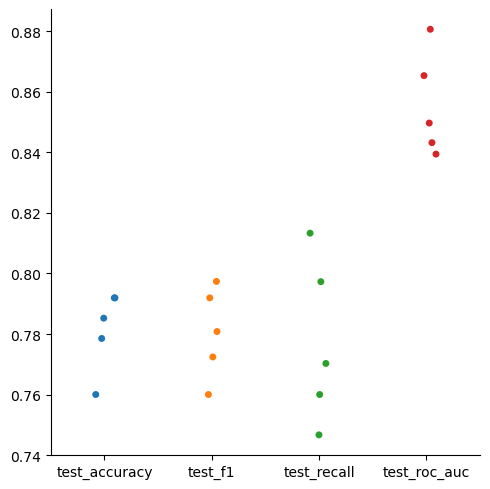

In [22]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.catplot(data=df_scores[['test_accuracy','test_f1','test_recall','test_roc_auc']])

## Entrainement sur tout le dataset

In [23]:
pipe.fit(X, y)
pipe.score(X, y)

1.0

## Sauvegarde

In [25]:
patat.util.file.pickle_save(pipe,'data/prod/230705-PredInfox.pkl')